## ETL

In [1]:
import numpy as np
from config import config
import db_module as dm
import pandas as pd
import psycopg2
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from time import time

In [2]:
cif = dm.DBConn()
query = str(
    "select * from dataentry_cifnepal as CIF inner join \
    dataentry_personboxnepal as PB on CIF.id = PB.cif_id;")
df = cif.ex_query(query)

In [34]:
# Data Processing / Create Unique Suspect ID number
dfcols = list(df.columns)
dfcols[16] = 'pv_occupation'
df.columns = dfcols

df['pb_number'] = df['pb_number'].fillna(0).astype(int)
df['suspect_id'] = df['cif_number'].str.replace('.', '')
df['suspect_id'] = df['suspect_id'].str[:-1] + ".PB" + df['pb_number'].map(str)
df = df.drop_duplicates(subset='suspect_id')

#Remove columns that won't be used
drop_cols = [
    'id',
    'date_time_entered_into_system',
    'status',
    'location',
    'date_time_last_updated',
    'staff_name',
    'informant_number',
    'case_notes',
    'pv_signed_form',
    'consent_for_fundraising',
    'social_media',
    'legal_action_taken_filed_against', 
    'officer_name',
    'cif_id',
    'person_id',
    'flag_count',
    'main_pv_id',
    'expected_earning',
    'expected_earning_currency',
    'travel_expenses_paid_to_broker_amount',
    'broker_relation',
    'travel_expenses_broker_repaid_amount',
    'form_entered_by_id', 
    'source_of_intelligence',
    'date_time_last_updated',
    'incident_date',
    'how_recruited_broker_other',
    'legal_action_taken',
    'legal_action_taken_case_type',
    'appearance',
    'date_visit_police_station',
    'victim_statement_certified_date',
    'purpose_for_leaving_other',
    'relation_to_pv',
    'exploitation_other_value'
]

for x in df.columns:
    if "contact" in x[:] or "_lb" in x[:] or "guardian" in x[:]: 
        drop_cols.append(x)

cif_df = df.drop(columns=drop_cols) # Subset used from here is "Case Information Form" (CIF)

In [35]:
#Add Arrest data
arrests = pd.read_csv("Arrests.csv")
cif_df = pd.merge(cif_df, arrests, how='outer', on='suspect_id', sort=True,
                  suffixes=('x', 'y'))
cif_df.Arrest = cif_df.Arrest.fillna('0').astype(int)
cif_df = cif_df.dropna(axis=0, subset=['cif_number'])

## Feature Engineering and Preprocessing Data

In [37]:
cif_df['planned_destination'] = cif_df['planned_destination'].str.replace(r'[^\w\s]+', '')
cif_df['destination_gulf'] = np.where(cif_df['planned_destination'].str.contains(
    'Gulf|Kuwait|Dubai|UAE|Oman|Saudi|Iraq|Qatar|Bahrain'),True,False)
cif_df['destination_unknown'] = np.where(
    cif_df['planned_destination'].str.contains('know'),True,False)

dest = ['Nepal',
        'India',
        'Delhi',
        'Gorakhpur',
        'Bihar',
        'Mumbai',
        'Sunauli',
        'Banaras',
        'Kolkata']

for d in dest:
    cif_df['destination_' + str(d)] = np.where(cif_df['planned_destination'].str.contains(d),True,False)

cif_df.pb_number = cif_df.pb_number.fillna(0)
cif_df.pb_number = cif_df.pb_number.astype(int)

PB_fields = [x for x in cif_df.columns if "_pb" in x[:]] 
#The variables in 'PB_fields' contain number(s) for the corresponding Person Box (PB) if the variable is relevant

def check_match(x):
    """Checks to see whether the first value is equal to or within the second value."""
    return str(x[0]) in list(str(x[1]))

for PBf in PB_fields:
    cif_df[PBf + "2"] = cif_df[['pb_number', PBf]].apply(check_match, axis=1)

cif_df = cif_df.drop(columns=['planned_destination', 'pb_number'])
cif_df = cif_df.drop(columns=PB_fields)


#Organizing/preprocessing data

num_features = ['number_of_victims',
                'number_of_traffickers',
                'known_broker_years',
                'known_broker_months',
                'married_broker_years',
                'married_broker_months',
                'reported_blue_flags',
                'total_blue_flags',
                'suspected_trafficker_count']

cat_features = ['education',
                'guardian_relationship',
                'station_id',
                'role',
                'pv_occupation',
                'occupation']

boolean_features = list(
    set(
        list(cif_df.columns)) - set(num_features) - set(cat_features) - set(['suspect_id', 
                                                                             'interview_date'])
)

cif_df[boolean_features] = cif_df[boolean_features].astype(bool)

cif_df[numerical_features] = cif_df[numerical_features].fillna(0).astype(float)

for f in categorical_features:
    cif_df[f] = cif_df[f].astype("category")

for cf in categorical_features:
    for elem in cif_df[cf].unique():
        cif_df[str(cf) + "_" + str(elem)] = cif_df[str(cf)] == elem
cif_df.drop(columns=categorical_features, inplace=True)
cif_df.drop(columns=['cif_number', 'Arrest_Date'], inplace=True)

# Remove non-arrest cases from the past 60 days
from datetime import date
today = date.today()
today.strftime("%m/%d/%Y")
cif_df['Days'] = (today - cif_df.loc[:,'interview_date']) / np.timedelta64(1, 'D')
df90p = cif_df[(cif_df['Days']>90) | (cif_df['Arrest']==True)]

# Train/Test Split
from sklearn.model_selection import train_test_split
X = (df90p.drop(columns=['Arrest',
                         'Days',
                         'interview_date',
                         'suspect_id']
               )
    )

y = df90p.Arrest

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, 
                                                                y_train, 
                                                                test_size=0.125)

## Building and Using Pipelines

In [137]:
class TypeSelector(BaseEstimator, TransformerMixin):
    """This is a class for applying transformations based on data type."""
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

transformer = Pipeline([
    ('features', FeatureUnion(n_jobs=1, transformer_list=[
        ('boolean', Pipeline([
            ('selector', TypeSelector('bool')),
        ])),
        
        ('numericals', Pipeline([
            ('selector', TypeSelector(np.number)),
            ('scaler', StandardScaler()),
        ]))
    ])),
])

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

cls_pipeline = Pipeline([
    ('transformer', transformer),
    ('clf', SGDClassifier())
])

cls_pipeline.fit(X_train, y_train)
y_sgd = cls_pipeline.decision_function(X_validation)

cls_pipeline.set_params(clf=RandomForestClassifier())
cls_pipeline.fit(X_train, y_train)
y_rf = cls_pipeline.predict_proba(X_validation)

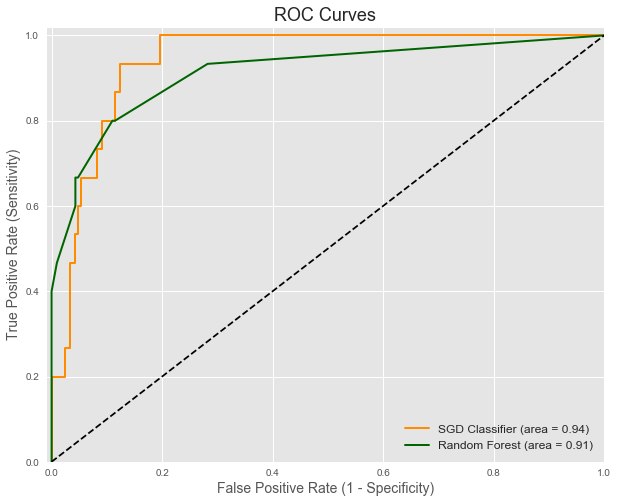

In [138]:
plt.style.use('ggplot')
%matplotlib inline

fpr, tpr, thresholds = roc_curve(y_validation, y_sgd)
roc_auc = auc(fpr, tpr)

rf_fpr, rf_tpr, thresholds = roc_curve(y_validation, y_rf[:, 1])
rf_roc_auc = auc(rf_fpr, rf_tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, 
         tpr, 
         color='darkorange',
         lw=2, 
         label='SGD Classifier (area=%0.2f)' % roc_auc)
plt.plot(rf_fpr, 
         rf_tpr, 
         color='darkgreen',
         lw=2, 
         label='Random Forest (area=%0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate (1 - Specificity)', size=14)
plt.ylabel('True Positive Rate (Sensitivity)', size=14)
plt.title('ROC Curves', fontsize=18)
plt.legend(loc="lower right", fontsize=12)
plt.show()

## Grid Search

In [142]:
search_space = [{'clf': [SGDClassifier()],
                 'clf__alpha': (0.00001, 0.000001),
                 'clf__penalty': ['l1','l2', 'elasticnet'],
                 'clf__learning_rate': ['optimal','adaptive'],
                 'clf__eta0': (0.00001, 0.000001),
                 'clf__class_weight': ['balanced',None]},
                {'clf': [RandomForestClassifier()],
                 'clf__bootstrap': [False, True],
                 'clf__n_estimators': [10,100],
                 'clf__max_depth': [5, 10, 20, 30, 40, 50, None],
                 'clf__max_features': [0.5, 0.6, 0.7, 0.8, 1],
                 'clf__class_weight': ["balanced", "balanced_subsample", None]}]
        
                 #'clf__min_samples_leaf': [10, 12, 15, 20, 50],

if __name__ == "__main__":
    grid_search = GridSearchCV(cls_pipeline, 
                               search_space, 
                               cv=5, n_jobs=-1, 
                               verbose=1)

    print("Performing grid search...")
    print("parameters:")
    print(search_space)
    t0 = time()
    best_model=grid_search.fit(X_train,y_train)
    print("done in %0.3fs" % (time() - t0))
    print()
    best_parameters = best_model.best_estimator_.get_params()['clf']
    
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    print(best_parameters)

Performing grid search...
parameters:
[{'clf': [SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)], 'clf__alpha': (1e-05, 1e-06), 'clf__penalty': ['l1', 'l2', 'elasticnet'], 'clf__learning_rate': ['optimal', 'adaptive'], 'clf__eta0': (1e-05, 1e-06), 'clf__class_weight': ['balanced', None]}, {'clf': [RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
         

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 2340 out of 2340 | elapsed: 30.0min finished
C:\Users\RandA\Anaconda3\envs\py36_32\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


done in 1798.097s

Best score: 0.934
Best parameters set:
RandomForestClassifier(bootstrap=False, class_weight='balanced',
            criterion='gini', max_depth=40, max_features=1,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)


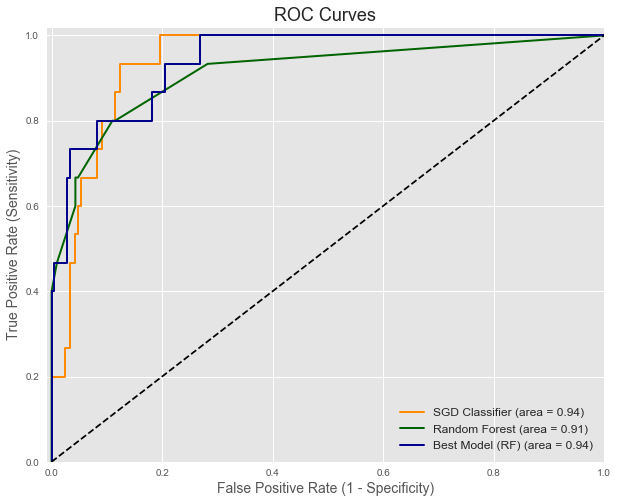

In [143]:
y_rf_best = best_model.predict_proba(X_validation)

fpr, tpr, thresholds = roc_curve(y_validation, y_sgd)
roc_auc = auc(fpr, tpr)

rf_fpr, rf_tpr, thresholds = roc_curve(y_validation, y_rf[:, 1])
rf_roc_auc = auc(rf_fpr, rf_tpr)

rf_best_fpr, rf_best_tpr, thresholds = roc_curve(y_validation, y_rf_best[:, 1])
rf_best_roc_auc = auc(rf_best_fpr, rf_best_tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, 
         tpr, 
         color='darkorange',
         lw=2, 
         label='SGD Classifier (area=%0.2f)' % roc_auc)
plt.plot(rf_fpr, 
         rf_tpr, 
         color='darkgreen',
         lw=2, 
         label='Random Forest (area=%0.2f)' % rf_roc_auc)
plt.plot(rf_best_fpr, 
         rf_best_tpr, 
         color='darkblue',
         lw=2, 
         label='Best Model (RF) (area=%0.2f)' % rf_best_roc_auc)
#plt.plot(cv_rf_fpr, cv_rf_tpr, color='blue',
#         lw=2, label='Random Forest CV (area = %0.2f)' % cv_rf_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate (1 - Specificity)', size=14)
plt.ylabel('True Positive Rate (Sensitivity)', size=14)
plt.title('ROC Curves', fontsize=18)
plt.legend(loc="lower right", fontsize=12)
plt.show()

In [16]:
threshold = 0.6

y_pred = (y_rf_best[:, 1]>=threshold).astype('int')
y_true = y_validation
target_names = ['No Arrest', 'Arrest']

print(classification_report(y_true, 
                            y_pred, 
                            target_names=target_names))

              precision    recall  f1-score   support

   No Arrest       0.94      0.98      0.96       207
      Arrest       0.67      0.40      0.50        20

   micro avg       0.93      0.93      0.93       227
   macro avg       0.81      0.69      0.73       227
weighted avg       0.92      0.93      0.92       227



In [160]:
# Run best model on all data and export results to csv
drop_cols = [
    'Arrest',
    'Days',
    'interview_date',
    'suspect_id'
]

dfa = cif_df.drop(columns=drop_cols,axis=1)
cif_df['soc'] = (best_model.predict_proba(dfa))[:, 1]
soc_df = cif_df[['suspect_id', 'soc']] 
soc_df.to_csv('soc.csv')